In [1]:
import math
import random
import numpy as np
import os
import fnmatch
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import shapelets as sha
import importlib
importlib.reload(sha)
from operator import itemgetter
#random.seed(1)
lcs=[]
classes=[]
xs=np.arange(0,30)
def noisy(average_value):
    return average_value+(math.cos(random.randint(0,360)*(math.pi/180))*0.1*average_value)
no_per_class=20
for i in range(no_per_class):
    ys=[]
    peak=np.random.choice(xs[1:-1])
    for x in xs:
        y=noisy(2)
        ys.append(y)
    ys[peak]=noisy(5)
    ys[peak-1]=noisy(5)
    ys[peak+1]=noisy(5)
    lcs.append(np.stack((xs,ys)))
    classes.append("alpha")
for i in range(no_per_class):
    ys=[]
    peak=np.random.choice(xs[:-1])
    for x in xs:
        y=noisy(2)
        ys.append(y)
    ys[peak]=noisy(10)
    lcs.append(np.stack((xs,ys)))
    classes.append("beta")
for i in range(no_per_class):
    ys=[]
    peak=np.random.choice(xs[:-3])
    for x in xs:
        y=noisy(2)
        ys.append(y)
    ys[peak]=noisy(10)
    #if peak<xs[-2]:
    ys[peak+2]=noisy(5)
    ys[peak+3]=noisy(5)
    lcs.append(np.stack((xs,ys)))
    classes.append("gamma")
for i in range(no_per_class):
    ys=[]
    #peak=np.random.choice(xs[:-3])
    for x in xs:
        y=noisy(2)
        ys.append(y)
    #ys[peak]=noisy(10)
    #if peak<xs[-2]:
    #ys[peak+2]=ys[peak+3]=noisy(5)
    lcs.append(np.stack((xs,ys)))
    classes.append("delta")
ids=[]
for i in range(len(classes)):
    ids.append(i)
ob_state = {}
for i, ob in enumerate(classes):
    ob_state[i] = ob

In [2]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(lcs, classes, ids, test_size=0.5, random_state=0, stratify=classes)

In [6]:
importlib.reload(sha)
best_shapelets=[]
time_res=1
for n_donor, lc_donor in enumerate(x_train):
    #Create lists with classifications of all time-series relative to the donor time series; one that the pool of shapelets is generated from
    state_donor = y_train[n_donor]
    belong_class=[]
    other_class=[]
    for n, i in enumerate(id_train):
        if y_train[n] == state_donor:
            belong_class.append(i)
        else:
            other_class.append(i)
    #calculate the entropy of the entire set, so it can be compared to the split set later
    prop_belong = len(belong_class)/(len(belong_class)+len(other_class))
    set_entropy = -(prop_belong)*math.log2(prop_belong)-(1-prop_belong)*math.log2(1-prop_belong)
    pool=sha.generate_shapelets(lc_donor, 1, len(lc_donor[0]))#generate shapelets from the donor time-series, 
    #set the initial best value of information gain to 0 (improved by any split) and start testing the shapelets
    best_gain=0
    for shapelet in pool:
        skip_shapelet=False#for entropy pruning
        #set the order of distance calculations
        #pick an other_class object first and then alternate between belong and other, when one group runs out, append the rest of the other group to the end
        order=[]
        if len(belong_class)<len(other_class):alternations=len(belong_class);larger_group=other_class
        else: alternations=len(other_class); larger_group=belong_class
        for i in range(alternations):
            order.append(other_class[i])
            order.append(belong_class[i])
        for i in range(len(larger_group)-alternations):
            order.append(larger_group[-(i+1)])
        #start distance calculations
        distances=[]
        for n_lc in order:
            if id_train[n_donor] == n_lc:
                distance = 0
            else:
                lc=x_train[np.where(np.array(id_train)==n_lc)[0][0]]
                distance=sha.distance_calculation(shapelet, lc, early_abandon=False)
            #save the distance value together with the classification and lightcurve id
            if n_lc in belong_class:
                class_assign=1
            else:
                class_assign=0
            distances.append((n_lc ,distance, class_assign))
            #find the optimal split point if there are at least two distances calculated, then use entropy pruning to find if the shapelet still has a change to beat the best one found so far
            if len(distances)>1:
                best_split=sha.best_split_point(distances, set_entropy)
                skip_shapelet=sha.entropy_pruning(best_gain, distances, best_split, len(belong_class), len(other_class), set_entropy)
                if skip_shapelet==True:
                    break
        #if shapelet was not rejected at entropy pruning, calculcate the information gain and if the value is larger then the best one so far, save the shapelet
        if skip_shapelet==False:
            gain=sha.information_gain(distances, set_entropy, best_split)
            if gain>best_gain:
                best_gain=gain
                best_shapelet=shapelet
    best_shapelets.append((best_shapelet, best_split, best_gain, id_train[n_donor], state_donor))

In [7]:
best_shapelets

[(array([2.2       , 2.19126095, 2.1       , 2.12586408, 2.07814623,
         2.16580751, 1.97216538, 1.85137103, 2.10598385, 1.86878819,
         1.80594085, 2.19562952, 2.15094192, 2.05176381, 2.        ,
         2.18910372, 1.80048719, 2.18126156, 2.1782013 , 1.82341048,
         1.87413592, 1.94823619, 1.93159597, 2.18793852, 1.99650952,
         1.91232577, 1.93159597, 2.17975881, 2.12586408]),
  74.92515905816869,
  0.8112781244591328,
  68,
  'delta'),
 (array([10.92050485,  2.120363  ,  4.50068523,  4.70610737]),
  74.92515905816869,
  0.8112781244591328,
  40,
  'gamma'),
 (array([ 1.80873905,  1.91865267,  1.83419249,  2.07814623,  1.85613204,
          2.0069799 ,  1.80594085,  1.82679492,  2.19225234,  2.14627074,
          2.19126095,  2.18910372, 10.08715574,  2.13893167,  2.19890438,
          2.0069799 ,  2.19972591,  2.1597271 ,  2.17975881,  1.8381966 ,
          1.88244295,  1.85372926,  1.88244295,  1.98256885]),
  0.3095234797980414,
  0.3671026561027332,
  31,
  

In [11]:
train_dists=np.zeros((len(x_train),len(best_shapelets)))
for i_t, t in enumerate(x_train):
    for i_s, s in enumerate(best_shapelets):
        distance=sha.distance_calculation(s[0], t, early_abandon=False)
        train_dists[i_t,i_s]=distance
train_dists

array([[0.00000000e+00, 1.38585439e+00, 1.19012920e+00, ...,
        6.67222706e+01, 2.00451005e+01, 6.67063585e+01],
       [9.81538382e-01, 0.00000000e+00, 6.70664170e-01, ...,
        6.61052543e+01, 1.88297802e+01, 6.60845937e+01],
       [8.29955158e-01, 6.70664170e-01, 0.00000000e+00, ...,
        6.61221790e+01, 1.89734082e+01, 6.60538346e+01],
       ...,
       [8.06424141e+01, 8.09591145e+01, 8.30604947e+01, ...,
        0.00000000e+00, 7.62372902e+00, 2.90729890e-02],
       [2.31805832e+01, 2.23268712e+01, 2.30251900e+01, ...,
        3.26368731e+01, 0.00000000e+00, 3.22939523e+01],
       [2.05816629e+01, 2.31410992e+01, 2.30235994e+01, ...,
        2.90729890e-02, 6.60906104e+00, 0.00000000e+00]])

In [26]:
from sklearn import tree
#x_tt, x_val, y_tt, y_val, id_tt, id_val = train_test_split(x_train, y_train, id_train, test_size=0.25, random_state=0, stratify=classes)
dtc=tree.DecisionTreeClassifier(criterion="entropy")
dtc.fit(train_dists, y_train)
inference= dtc.predict(train_dists)
score=[]
for n, i in enumerate(inference):
    if i ==y_train[n]:
        score.append(1)
    else:
        score.append(0)
score=np.array(score)
np.mean(score)

1.0

In [22]:
test_dists=np.zeros((len(x_test),len(best_shapelets)))
for i_t, t in enumerate(x_test):
    for i_s, s in enumerate(best_shapelets):
        distance=sha.distance_calculation(s[0], t, early_abandon=False)
        test_dists[i_t,i_s]=distance
test_dists

array([[ 0.86220275,  1.21141902,  1.03227234, ..., 66.0523186 ,
        18.90504034, 66.01959698],
       [72.74859185, 72.72428739, 75.04553575, ...,  0.35284983,
         7.93737353,  0.30605138],
       [52.7731382 , 51.49167111, 51.34067518, ..., 11.07866508,
        19.07485799, 10.29091068],
       ...,
       [30.775544  , 27.73154923, 26.89404905, ..., 34.5631251 ,
         0.59362614, 34.22608928],
       [48.55097363, 47.47533552, 47.75337401, ..., 12.02940372,
        20.22403424, 11.28039741],
       [65.00010998, 63.05143449, 62.31402563, ...,  0.32138539,
         8.33017948,  0.36371586]])

In [88]:
dtc=tree.DecisionTreeClassifier(criterion="entropy")
dtc.fit(train_dists, y_train)
inference= dtc.predict(test_dists)
score=[]
for n, i in enumerate(inference):
    if i ==y_test[n]:
        score.append(1)
    else:
        score.append(0)
        print(y_test[n], i)
score=np.array(score)
np.mean(score)

beta delta


0.99

In [13]:
from sklearn.model_selection import train_test_split

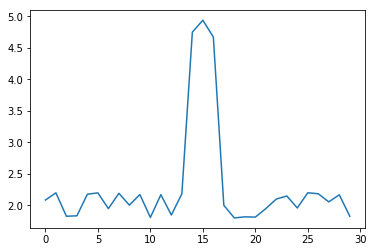

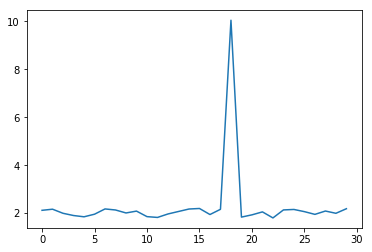

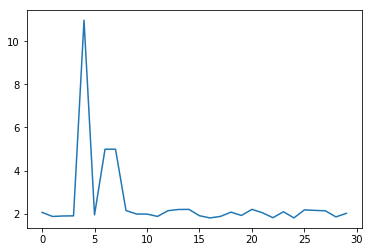

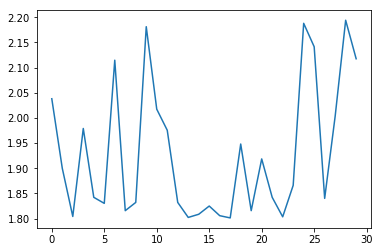

In [89]:
for n, lc in enumerate(lcs):
    if n in [1,60,125,199]:
        plt.plot(lc[0],lc[1])
        plt.show()